In [1]:
!pip install pmdarima

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
tensorflow-intel 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.22.4 which is incompatible.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.22.4 which is incompatible.



  Using cached packaging-23.2-py3-none-any.whl (53 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.3
    Uninstalling numpy-1.26.3:
      Successfully uninstalled numpy-1.26.3
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.2
    Uninstalling patsy-0.5.2:
      Successfully uninstalled patsy-0.5.2
  Attempting uninstall: packaging
    Found existing installation: packaging 21.0
    Uninstalling packaging-21.0:
      Successfully uninstalled packaging-21.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [4]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('PNJ.csv',sep=',', date_parser=dateparse).fillna(0)

In [5]:
df = stock_data.rename(columns={'Date/Time':'Date'})
df

,Ticker,Date,Open,High,Low,Close,Volume,Open Interest
0,PNJ,2/28/2018 9:15,78.14,78.99,78.14,78.99,270,0
1,PNJ,2/28/2018 9:16,78.94,78.94,78.94,78.94,10,0
2,PNJ,2/28/2018 9:19,78.14,78.14,78.14,78.14,283,0
3,PNJ,2/28/2018 9:20,78.14,78.14,78.14,78.14,480,0
4,PNJ,2/28/2018 9:21,78.14,78.14,78.14,78.14,146,0
...,...,...,...,...,...,...,...,...
125304,PNJ,12/22/2020 14:22,78.20,78.20,78.20,78.20,5000,0
125305,PNJ,12/22/2020 14:23,78.20,78.20,78.20,78.20,1700,0
125306,PNJ,12/22/2020 14:24,78.20,78.20,78.20,78.20,870,0
125307,PNJ,12/22/2020 14:25,78.10,78.10,78.10,78.10,13000,0


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [8]:
df

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date,,,,,,,
2018-02-28 09:15:00,PNJ,78.14,78.99,78.14,78.99,270,0
2018-02-28 09:16:00,PNJ,78.94,78.94,78.94,78.94,10,0
2018-02-28 09:19:00,PNJ,78.14,78.14,78.14,78.14,283,0
2018-02-28 09:20:00,PNJ,78.14,78.14,78.14,78.14,480,0
2018-02-28 09:21:00,PNJ,78.14,78.14,78.14,78.14,146,0
...,...,...,...,...,...,...,...
2020-12-22 14:22:00,PNJ,78.20,78.20,78.20,78.20,5000,0
2020-12-22 14:23:00,PNJ,78.20,78.20,78.20,78.20,1700,0
2020-12-22 14:24:00,PNJ,78.20,78.20,78.20,78.20,870,0


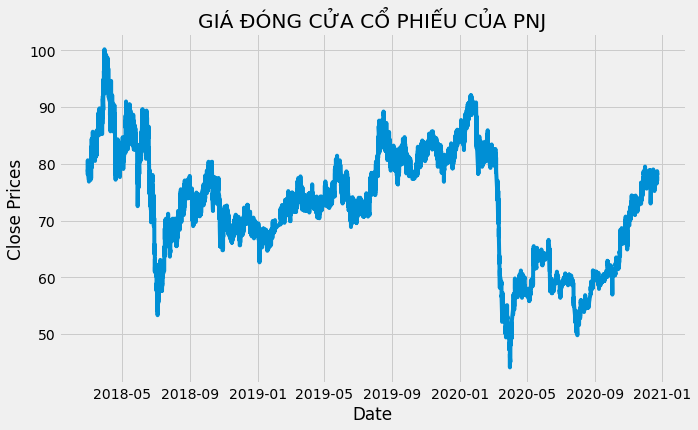

In [12]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'],lw=4)
plt.title('GIÁ ĐÓNG CỬA CỔ PHIẾU CỦA PNJ')
plt.show()

<AxesSubplot:ylabel='Density'>

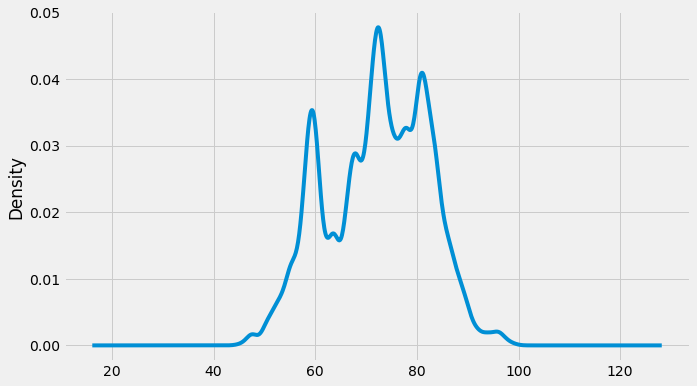

In [18]:
#phân phối tập dữ liệu
df['Close'].plot(kind='kde')

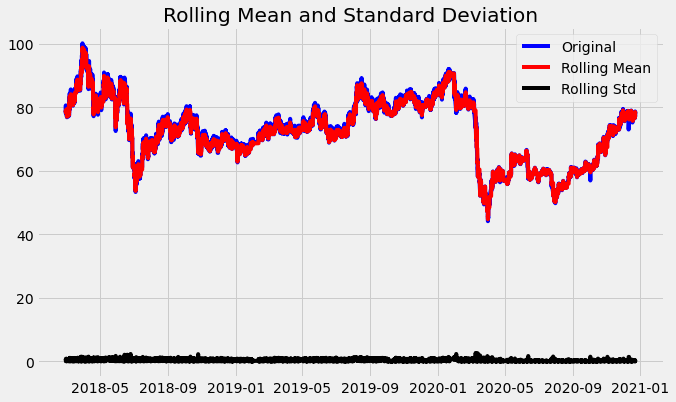

Results of dickey fuller test
Test Statistics                    -1.957978
p-value                             0.305297
No. of lags used                   43.000000
Number of observations used    125265.000000
critical value (1%)                -3.430402
critical value (5%)                -2.861563
critical value (10%)               -2.566782
dtype: float64


In [20]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df['Close'])

<Figure size 720x432 with 0 Axes>

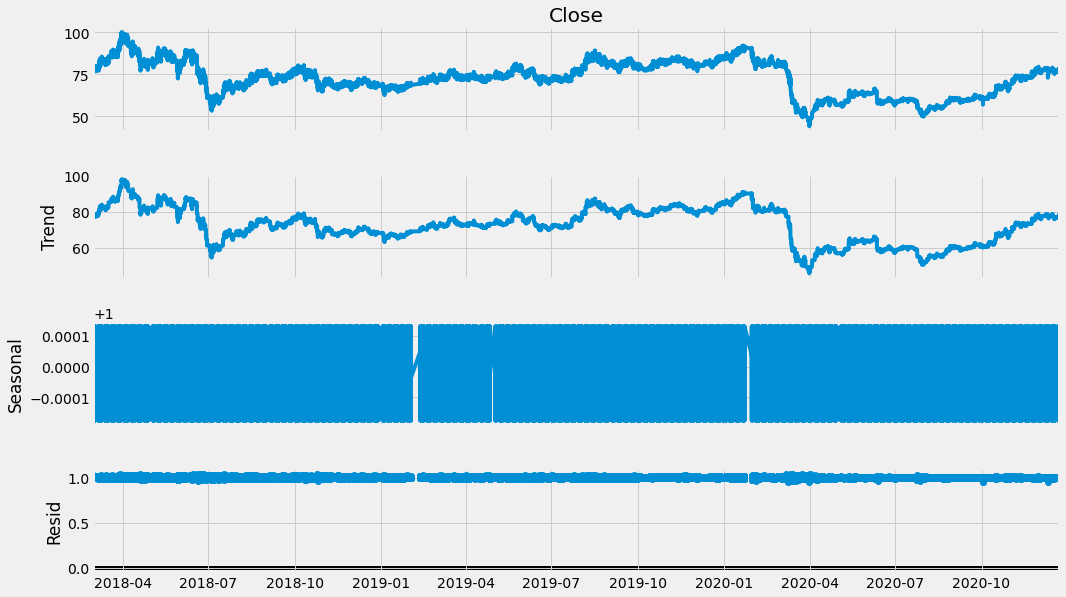

In [24]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df['Close'], model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


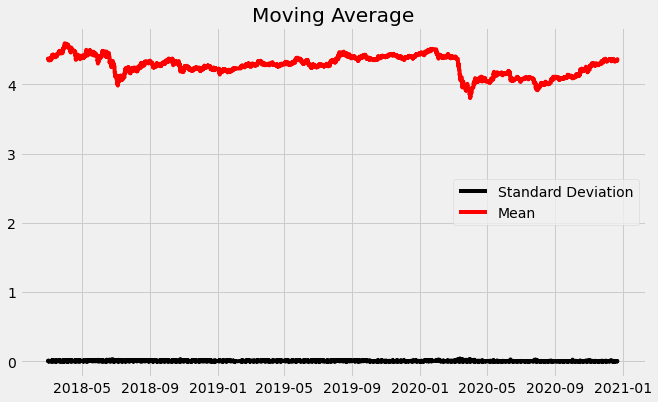

In [25]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

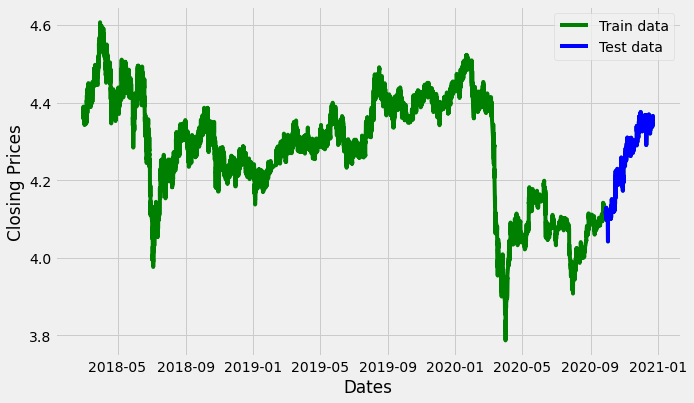

In [26]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-732472.783, Time=10.86 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-762178.483, Time=14.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-782845.721, Time=28.94 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-732474.777, Time=6.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-782889.828, Time=59.93 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-782867.398, Time=78.79 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-783753.930, Time=71.75 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-783763.396, Time=28.94 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-783802.321, Time=35.39 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-783795.799, Time=42.97 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-783804.219, Time=17.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-783765.826, Time=24.29 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-783797.896, Time=33.86 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-78375

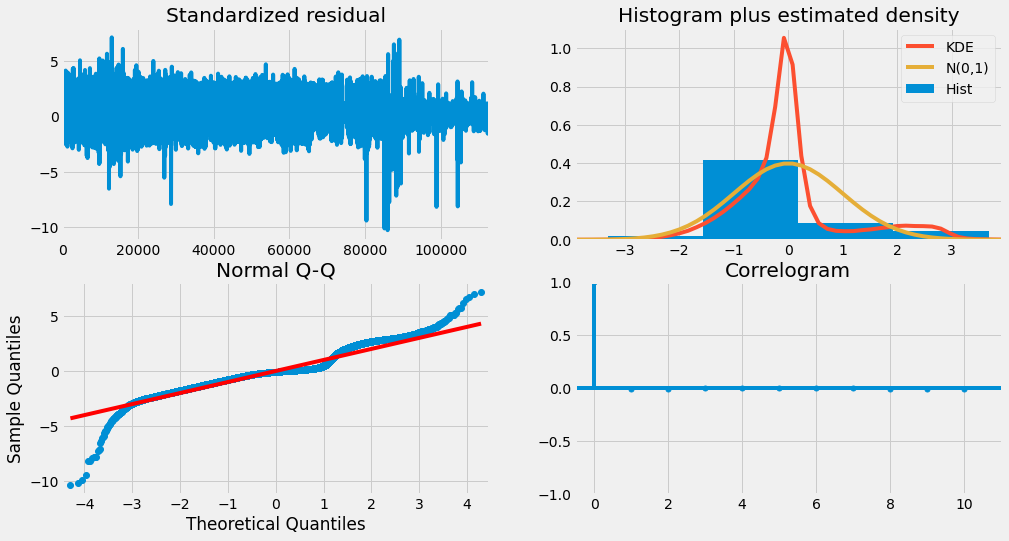

In [27]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [47]:
from statsmodels.tsa.arima.model import ARIMA
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:               112775
Model:                 ARIMA(1, 1, 2)   Log Likelihood              391881.993
Date:                Wed, 24 Jan 2024   AIC                        -783755.987
Time:                        17:17:47   BIC                        -783717.454
Sample:                             0   HQIC                       -783744.356
                             - 112775                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7112      0.239     -2.977      0.003      -1.179      -0.243
ma.L1         -0.0365      0.240     -0.152      0.879      -0.506       0.433
ma.L2         -0.5269      0.179     -2.941      0.0

In [85]:
# Forecast
#result = fitted.forecast(321, alpha=0.05)

# In kết quả để xem cấu trúc của tuple
#print(result)

# Kiểm tra độ dài của tuple để xem có bao nhiêu giá trị
#print(len(result))

# Nếu có nhiều hơn 3 giá trị, bạn có thể giữ lại một số giá trị hoặc sử dụng slicing
#fc, se, conf = result[:3]

112775    4.118176
112776    4.118175
112777    4.118176
112778    4.118175
112779    4.118175
            ...   
113091    4.118175
113092    4.118175
113093    4.118175
113094    4.118175
113095    4.118175
Name: predicted_mean, Length: 321, dtype: float64
321


In [87]:
fc, se, conf = fitted.forecast(321, alpha=0.05)

ValueError: too many values to unpack (expected 3)

In [86]:
print(fc)
print(se)
print(conf)

4.118176089982598
4.118174589289919
4.118175656602163


In [84]:

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Dự đoán giá cổ phiếu PNJ')
plt.xlabel('Time')
plt.ylabel('Giá Cổ Phiếu PNJ')
plt.legend(loc='upper left', fontsize=8)
plt.show()

TypeError: 'float' object is not subscriptable